In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import time
import gc
import pathlib
from matplotlib import ticker

In [2]:
save_plots = True

## 5500 or 0, usually
lambda_lower_bound = 0

## Create plots directory, if missing
plotsDirectory = (str(pathlib.Path.home())
                  + '/vertex-reconstruction-studies/plots/studies_on_full_data/'
                  + 'variable_distribution_comparison/')
pathlib.Path(plotsDirectory).mkdir(parents=True, exist_ok=True)

In [3]:
def MomentumModulus(px, py, pz):
    return np.sqrt(px**2 + py**2 + pz**2)

def TransverseMomentumModulus(px, py):
    return np.sqrt(px**2 + py**2)

# Import Monte Carlo data

In [4]:
inputMC = '~/data/LHCbMC_2016-2017-2018_MagUpDown_Lb2JPsiL_Ttracks_v12.h5'

In [5]:
tick = time.perf_counter()
df_MC_reco = pd.read_hdf(inputMC, key='LHCbMC_Lb')
tock = time.perf_counter()
print(f"Monte Carlo imported in {tock - tick:0.4f} seconds.")

Monte Carlo imported in 0.8921 seconds.


In [6]:
tick = time.perf_counter()
df_MC_truth = pd.read_hdf(inputMC, key='LHCbMCTruth_Lb')
tock = time.perf_counter()
print(f"Monte Carlo Truth imported in {tock - tick:0.4f} seconds.")

Monte Carlo Truth imported in 14.0890 seconds.


In [7]:
tick = time.perf_counter()
df_MC = pd.merge(df_MC_truth, df_MC_reco.loc[df_MC_reco['MC_key'] >= 0, :].drop('TrackType', axis='columns').groupby('MC_key').first(), how='left', on='MC_key')
tock = time.perf_counter()
print(f"Monte Carlo merged in {tock - tick:0.4f} seconds.")

Monte Carlo merged in 157.7417 seconds.


In [8]:
## Cut on true Lambda decay vertex. 8000 is the maximum to have events,
## no Lambda in the MC decays farther than that.
LambdaZVertexLowerBound = lambda_lower_bound
LambdaZVertexUpperBound = 8000
df_MC = df_MC[(df_MC['MCTRUTH_L_ENDVERTEX_Z'] > LambdaZVertexLowerBound) & (df_MC['MCTRUTH_L_ENDVERTEX_Z'] < LambdaZVertexUpperBound)]
df_MC

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsiLambda_PIDSubs_pim_PZ,DTF_FixJPsiLambda_PIDSubs_p_PX,DTF_FixJPsiLambda_PIDSubs_p_PY,DTF_FixJPsiLambda_PIDSubs_p_PZ,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ
MC_key,,,,,,,,,,,,,,,,,,,,,
0,0.9512,-0.1669,26.401600,343.742889,-192.429398,4751.548828,2031.640015,-1218.119995,29336.890625,445.510010,...,32905.289062,292.816681,-186.566345,5411.963379,-804.469727,-535.944397,22858.960938,1438.071777,1619.34729,23634.302734
1,0.4619,-0.3471,-52.081200,-19.765400,-33.384300,45.136002,-1190.050049,-1817.560059,5618.410156,-125.169998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.8623,-0.0693,39.078201,145.114395,-70.015701,2563.685059,1349.000000,-574.190002,22276.189453,239.940002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.8441,-0.1694,17.714300,-9.207400,27.546700,3520.887207,-295.320007,790.229980,93841.296875,3.170000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.6610,-0.4327,7.083600,-23.592199,-54.290798,201.384293,-1843.489990,-4303.959961,15525.910156,-361.470001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921810,0.7382,-0.1062,0.347100,-2.454600,0.459400,68.980499,-1052.079956,169.649994,21721.480469,-270.470001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8921811,0.6401,-0.0814,27.420200,4.920900,-10.475100,58.229698,680.200012,-1542.880005,4852.310059,153.279999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8921812,2.0908,-1.0901,46.602200,36.268501,-29.632999,1175.768677,4569.680176,-3904.929932,153438.671875,582.070007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
## Cleanup
del(df_MC_truth)
del(df_MC_reco)
gc.collect()

0

# Selection definitions

In [10]:
## Select reconstructed muons. There is a very small (~4500) number of reconstructed events
## where the 'PID_Reconstructed' variables do not match the corresponding 'PID_Reconstructible'.
reconstructibleMuons = (df_MC['mum_Reconstructible']=='ChargedLong') & (df_MC['mup_Reconstructible']=='ChargedLong')
reconstructedMuons = (df_MC['mum_Reconstructed']=='ChargedLong') & (df_MC['mup_Reconstructed']=='ChargedLong')

## The mismatched events here are a bit more (~11k). I suppose this could be because of particles
## potentially reconstructible as something "better" than TTRACKS (e.g. LONG) that get a degreaded result.
reconstructibleTTracks = (df_MC['pim_Reconstructible']=='ChargedTtrack') & (df_MC['p_Reconstructible']=='ChargedTtrack')
reconstructedTTracks = (df_MC['pim_Reconstructed']=='ChargedTtrack') & (df_MC['p_Reconstructed']=='ChargedTtrack')

## This selects all events actually reconstructed in the MC_reco. Since we have constrained reconstruction
## of muons, protons and pions, the deficit must be due to Lambda and/or Lambdab reconstrution failure.
## (Or J/psi, sure, but we assume that two LONG muons are tracked much better than two TTRACKS proton and pions.)
allReconstructedEvents = ((df_MC['Rec_key'] >= 0) & (df_MC['TrackType'] == 'T'))

In [11]:
selectionCandidates = (
    reconstructibleMuons & reconstructedMuons
    & reconstructibleTTracks & reconstructedTTracks
)
    
selectionPassed = selectionCandidates & allReconstructedEvents

In [12]:
df_MC_Reconstructed = df_MC[selectionPassed]
df_MC_Failed = df_MC[selectionCandidates & ~selectionPassed]

In [13]:
df_MC_Reconstructed

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsiLambda_PIDSubs_pim_PZ,DTF_FixJPsiLambda_PIDSubs_p_PX,DTF_FixJPsiLambda_PIDSubs_p_PY,DTF_FixJPsiLambda_PIDSubs_p_PZ,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ
MC_key,,,,,,,,,,,,,,,,,,,,,
0,0.9512,-0.1669,26.401600,343.742889,-192.429398,4751.548828,2031.640015,-1218.119995,29336.890625,445.510010,...,32905.289062,292.816681,-186.566345,5411.963379,-804.469727,-535.944397,22858.960938,1438.071777,1619.347290,23634.302734
29,0.8237,-0.2123,3.514200,140.238602,325.837311,7463.102539,367.250000,1035.959961,24602.169922,174.279999,...,25203.607422,171.069519,222.666214,4137.976074,-605.608093,594.454895,11170.495117,71.893692,-2873.631348,73489.484375
69,-0.4798,-0.7758,18.706800,-785.810974,-591.072998,5157.507812,-5172.310059,-3904.530029,34147.730469,-470.119995,...,35743.000000,-364.151062,-323.442810,2628.927246,4.108163,-790.314697,5651.807129,-5579.078613,-431.151581,23151.667969
119,1.6829,-2.2522,-36.520901,94.709503,-270.525391,3823.881348,5635.350098,-15984.469727,230495.453125,604.909973,...,188402.296875,413.837830,-1702.511353,24506.517578,8712.822266,-18033.572266,231397.500000,336.531647,-3496.248779,45100.238281
202,2.2347,-3.0136,-3.515400,-41.785000,-495.398499,2890.112793,-144.789993,-1430.229980,8650.469727,-27.309999,...,8376.690430,39.732117,-514.345398,2560.247559,2766.051025,-6544.098633,37503.421875,4405.509766,-5917.182129,27155.025391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921673,0.9741,0.2091,-11.659000,294.090698,39.875000,7125.287109,2412.750000,405.109985,60216.011719,395.200012,...,57967.937500,369.589996,-18.306223,7767.518555,1504.345581,715.472656,49351.718750,-112.221489,2933.706299,37641.914062
8921702,-0.5103,1.2180,21.928400,-148.940399,123.715599,7319.557129,-1238.500000,978.909973,57653.351562,-45.599998,...,109052.914062,92.123260,-50.586430,-2812.631592,-3547.666504,1885.741577,33505.289062,-1337.816284,1466.083374,45027.328125
8921772,0.1275,-0.0589,25.113001,-123.851601,-28.034100,2985.664307,-6471.830078,-1487.530029,153226.906250,-561.440002,...,164034.843750,-634.271484,-133.646973,15975.192383,-3526.683594,-343.335175,44636.988281,-3534.635254,-3121.734619,91762.195312


In [14]:
df_MC_Failed

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsiLambda_PIDSubs_pim_PZ,DTF_FixJPsiLambda_PIDSubs_p_PX,DTF_FixJPsiLambda_PIDSubs_p_PY,DTF_FixJPsiLambda_PIDSubs_p_PZ,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ
MC_key,,,,,,,,,,,,,,,,,,,,,
14,0.8581,-0.2143,-37.491299,120.038399,-188.841202,2945.801758,1459.030029,-2458.459961,38212.730469,471.339996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,0.8102,-0.1997,32.725700,-116.077301,-142.194305,2938.737793,-1559.530029,-1963.800049,38707.769531,-428.540009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,-0.7972,0.2901,102.594597,-128.295105,-22.189400,3564.520996,-2886.939941,-478.269989,79179.851562,-921.289978,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,0.8580,-0.3398,-17.450899,-8.141000,-58.818100,2458.789795,-239.529999,-1307.089966,59011.390625,-2.520000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,1.1415,-0.1372,-0.366000,117.986603,-12.921000,3889.503418,4111.229980,-518.090027,135508.343750,1006.309998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921706,1.2308,-0.4562,29.103100,379.500092,-334.055206,3283.919189,3707.600098,-3256.340088,32327.039062,436.109985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8921717,0.8388,0.0936,37.709099,359.449097,73.624901,4885.538086,2260.610107,459.140015,31560.830078,704.919983,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8921720,0.8952,0.1660,34.345299,289.808411,99.849701,6048.000488,3167.560059,1126.670044,64279.128906,446.690002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Distribution comparison

## $\Lambda_b$ decay vertices

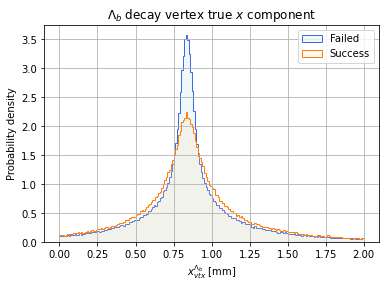

In [15]:
featureToPlot = 'MCTRUTH_Lb_ENDVERTEX_X'
featureLabel = '$x^{\Lambda_b}_{vtx}$ [mm]'
featureTitle = '$\Lambda_b$ decay vertex true $x$ component'
binNumber = 200
boundaries = (0,2)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + featureToPlot + '.pdf', bbox_inches='tight')
plt.show()

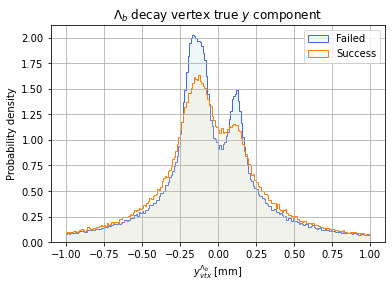

In [16]:
featureToPlot = 'MCTRUTH_Lb_ENDVERTEX_Y'
featureLabel = '$y^{\Lambda_b}_{vtx}$ [mm]'
featureTitle = '$\Lambda_b$ decay vertex true $y$ component'
binNumber = 200
boundaries = (-1,1)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + featureToPlot + '.pdf', bbox_inches='tight')
plt.show()

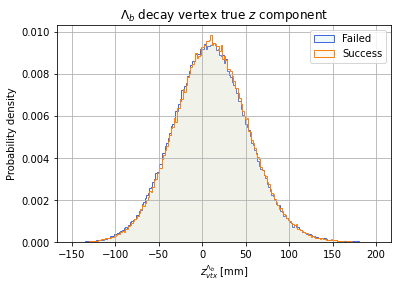

In [17]:
featureToPlot = 'MCTRUTH_Lb_ENDVERTEX_Z'
featureLabel = '$z^{\Lambda_b}_{vtx}$ [mm]'
featureTitle = '$\Lambda_b$ decay vertex true $z$ component'
binNumber = 200
boundaries = (-150,200)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + featureToPlot + '.pdf', bbox_inches='tight')
plt.show()

## $\Lambda$ decay vertices

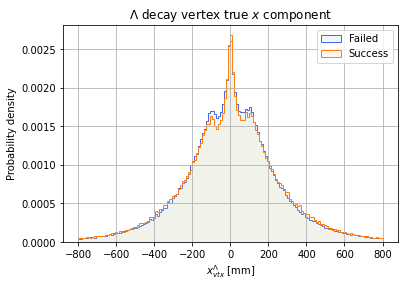

In [18]:
featureToPlot = 'MCTRUTH_L_ENDVERTEX_X'
featureLabel = '$x^{\Lambda}_{vtx}$ [mm]'
featureTitle = '$\Lambda$ decay vertex true $x$ component'
binNumber = 150
boundaries = (-800,800)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + featureToPlot + '.pdf', bbox_inches='tight')
plt.show()

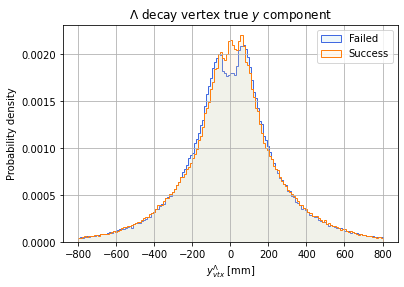

In [19]:
featureToPlot = 'MCTRUTH_L_ENDVERTEX_Y'
featureLabel = '$y^{\Lambda}_{vtx}$ [mm]'
featureTitle = '$\Lambda$ decay vertex true $y$ component'
binNumber = 150
boundaries = (-800,800)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + featureToPlot + '.pdf', bbox_inches='tight')
plt.show()

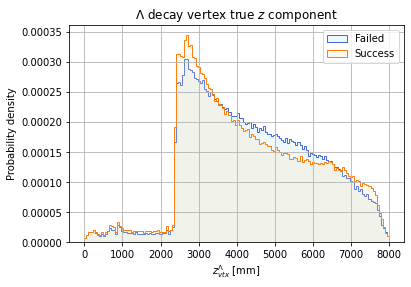

In [20]:
featureToPlot = 'MCTRUTH_L_ENDVERTEX_Z'
featureLabel = '$z^{\Lambda}_{vtx}$ [mm]'
featureTitle = '$\Lambda$ decay vertex true $z$ component'
binNumber = 150
boundaries = (lambda_lower_bound,8000)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + featureToPlot + '.pdf', bbox_inches='tight')
plt.show()

## Proton momenta

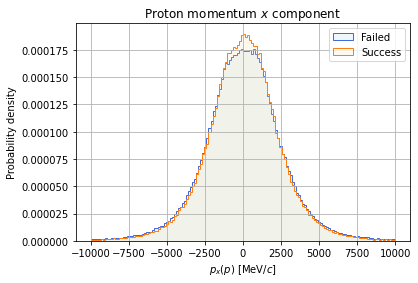

In [21]:
featureToPlot = 'MCTRUTH_p_PX'
featureLabel = '$p_x (p)$ [MeV/$c$]'
featureTitle = 'Proton momentum $x$ component'
binNumber = 150
boundaries = (-1e4,1e4)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + featureToPlot + '.pdf', bbox_inches='tight')
plt.show()

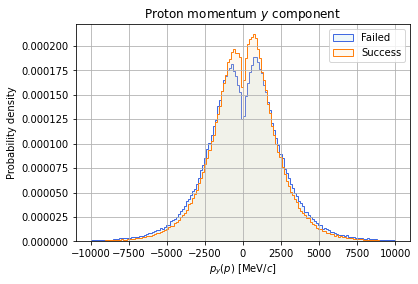

In [22]:
featureToPlot = 'MCTRUTH_p_PY'
featureLabel = '$p_y (p)$ [MeV/$c$]'
featureTitle = 'Proton momentum $y$ component'
binNumber = 150
boundaries = (-1e4,1e4)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + featureToPlot + '.pdf', bbox_inches='tight')
plt.show()

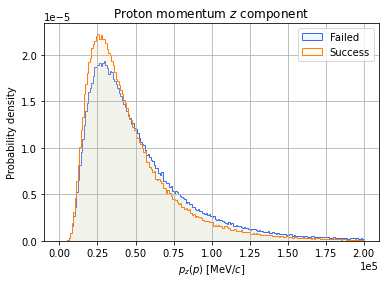

In [23]:
featureToPlot = 'MCTRUTH_p_PZ'
featureLabel = '$p_z (p)$ [MeV/$c$]'
featureTitle = 'Proton momentum $z$ component'
binNumber = 200
boundaries = (0,2e5)
yscale = 'linear'
normalized = True
scientific = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)

if scientific:
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + featureToPlot + '.pdf', bbox_inches='tight')
plt.show()

## Pion momenta

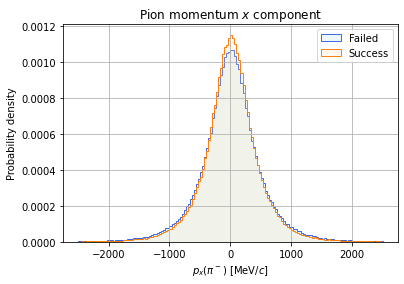

In [24]:
featureToPlot = 'MCTRUTH_pim_PX'
featureLabel = '$p_x (\pi^-)$ [MeV/$c$]'
featureTitle = 'Pion momentum $x$ component'
binNumber = 150
boundaries = (-2500,2500)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + featureToPlot + '.pdf', bbox_inches='tight')
plt.show()

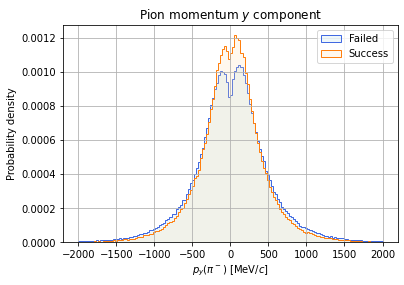

In [25]:
featureToPlot = 'MCTRUTH_pim_PY'
featureLabel = '$p_y (\pi^-)$ [MeV/$c$]'
featureTitle = 'Pion momentum $y$ component'
binNumber = 150
boundaries = (-2000,2000)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + featureToPlot + '.pdf', bbox_inches='tight')
plt.show()

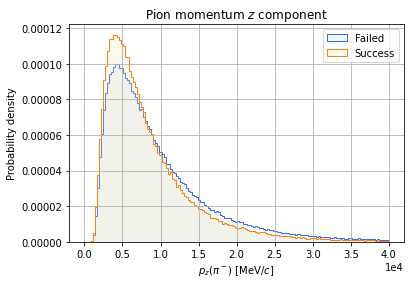

In [26]:
featureToPlot = 'MCTRUTH_pim_PZ'
featureLabel = '$p_z (\pi^-)$ [MeV/$c$]'
featureTitle = 'Pion momentum $z$ component'
binNumber = 150
boundaries = (0,40000)
yscale = 'linear'
normalized = True
scientific = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)

if scientific:
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + featureToPlot + '.pdf', bbox_inches='tight')
plt.show()

## Muon momenta

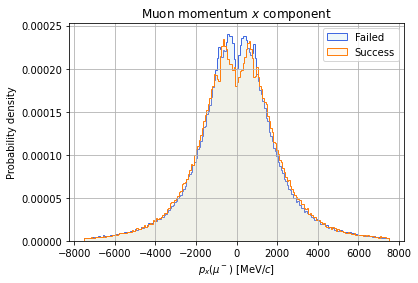

In [27]:
featureToPlot = 'MCTRUTH_mum_PX'
featureLabel = '$p_x (\mu^-)$ [MeV/$c$]'
featureTitle = 'Muon momentum $x$ component'
binNumber = 200
boundaries = (-7.5e3,7.5e3)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + featureToPlot + '.pdf', bbox_inches='tight')
plt.show()

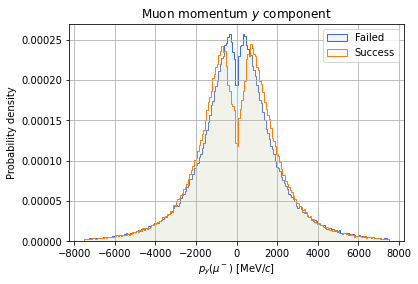

In [28]:
featureToPlot = 'MCTRUTH_mum_PY'
featureLabel = '$p_y (\mu^-)$ [MeV/$c$]'
featureTitle = 'Muon momentum $y$ component'
binNumber = 200
boundaries = (-7.5e3,7.5e3)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + featureToPlot + '.pdf', bbox_inches='tight')
plt.show()

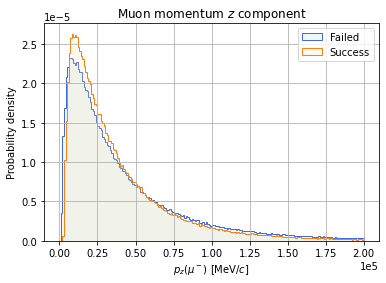

In [29]:
featureToPlot = 'MCTRUTH_mum_PZ'
featureLabel = '$p_z (\mu^-)$ [MeV/$c$]'
featureTitle = 'Muon momentum $z$ component'
binNumber = 200
boundaries = (0,2e5)
yscale = 'linear'
normalized = True
scientific = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)

if scientific:
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + featureToPlot + '.pdf', bbox_inches='tight')
plt.show()

## Antimuon momenta

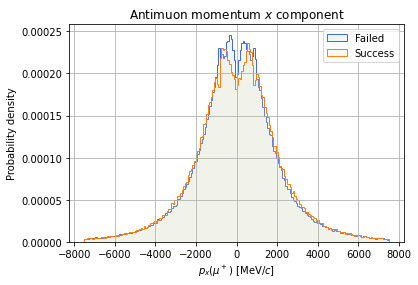

In [30]:
featureToPlot = 'MCTRUTH_mup_PX'
featureLabel = '$p_x (\mu^+)$ [MeV/$c$]'
featureTitle = 'Antimuon momentum $x$ component'
binNumber = 200
boundaries = (-7.5e3,7.5e3)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + featureToPlot + '.pdf', bbox_inches='tight')
plt.show()

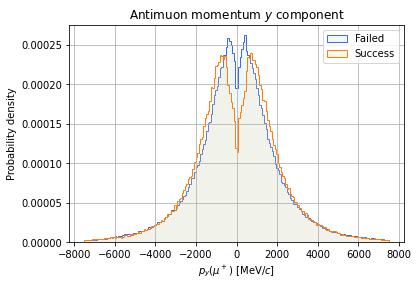

In [31]:
featureToPlot = 'MCTRUTH_mup_PY'
featureLabel = '$p_y (\mu^+)$ [MeV/$c$]'
featureTitle = 'Antimuon momentum $y$ component'
binNumber = 200
boundaries = (-7.5e3,7.5e3)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + featureToPlot + '.pdf', bbox_inches='tight')
plt.show()

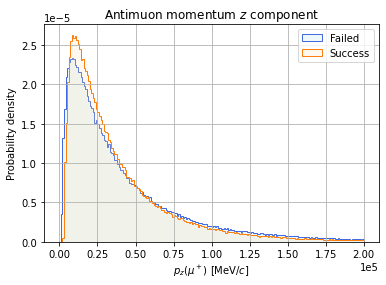

In [32]:
featureToPlot = 'MCTRUTH_mup_PZ'
featureLabel = '$p_z (\mu^+)$ [MeV/$c$]'
featureTitle = 'Antimuon momentum $z$ component'
binNumber = 200
boundaries = (0,2e5)
yscale = 'linear'
normalized = True
scientific = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)

if scientific:
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + featureToPlot + '.pdf', bbox_inches='tight')
plt.show()

## `Lb_ID`

In [33]:
## Index: where we plot the bars
## bar_width: smaller so we can fit both training and test data
indexes = np.arange(2)
bar_width=0.4

In [34]:
Lb_ID_reco = df_MC_Reconstructed['MCTRUTH_Lb_ID'].value_counts()/sum(df_MC_Reconstructed['MCTRUTH_Lb_ID'].value_counts())
Lb_ID_fail = df_MC_Failed['MCTRUTH_Lb_ID'].value_counts()/sum(df_MC_Failed['MCTRUTH_Lb_ID'].value_counts())
Lb_ID_Labels = list(Lb_ID_fail.index)

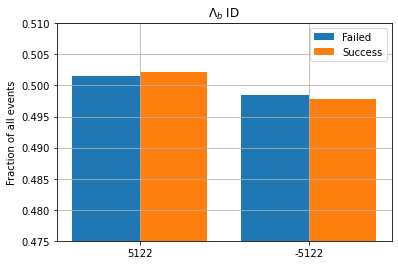

In [35]:
featureToPlot = 'MCTRUTH_Lb_ID'
featureTitle = '$\Lambda_b$ ID'
valueRange=(0.475,0.51)

reco_ID = Lb_ID_reco
fail_ID = Lb_ID_fail
labels = Lb_ID_Labels

## Failed plot
plt.bar(
    x=indexes,
    height=fail_ID,
    width=bar_width,
    label='Failed',
    color='tab:blue'
)


## Reco plot
plt.bar(
    x=indexes+bar_width,
    height=reco_ID,
    width=bar_width,
    label='Success',
    color='tab:orange'
)

## Set actual label of x-axis
ax = plt.gca()
ax.set_xticks(indexes+.5*bar_width)
ax.set_xticklabels(labels)

## Misc
plt.ylim(valueRange)
plt.title(featureTitle)
plt.ylabel('Fraction of all events')
plt.grid()
plt.legend()
plt.show()

## `L_ID`

In [36]:
L_ID_reco = df_MC_Reconstructed['MCTRUTH_L_ID'].value_counts()/sum(df_MC_Reconstructed['MCTRUTH_L_ID'].value_counts())
L_ID_fail = df_MC_Failed['MCTRUTH_L_ID'].value_counts()/sum(df_MC_Failed['MCTRUTH_L_ID'].value_counts())
L_ID_Labels = list(L_ID_reco.index)

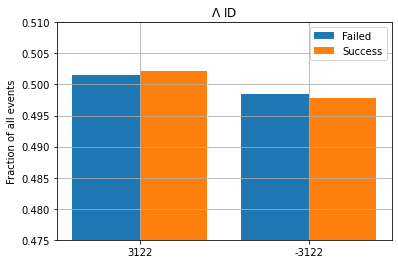

In [37]:
featureToPlot = 'MCTRUTH_L_ID'
featureTitle = '$\Lambda$ ID'
valueRange=(0.475,0.51)

reco_ID = L_ID_reco
fail_ID = L_ID_fail
labels = L_ID_Labels

## Failed plot
plt.bar(
    x=indexes,
    height=fail_ID,
    width=bar_width,
    label='Failed',
    color='tab:blue'
)


## Reco plot
plt.bar(
    x=indexes+bar_width,
    height=reco_ID,
    width=bar_width,
    label='Success',
    color='tab:orange'
)

## Set actual label of x-axis
ax = plt.gca()
ax.set_xticks(indexes+.5*bar_width)
ax.set_xticklabels(labels)

## Misc
plt.ylim(valueRange)
plt.title(featureTitle)
plt.ylabel('Fraction of all events')
plt.grid()
plt.legend()
plt.show()

## `p_PP`

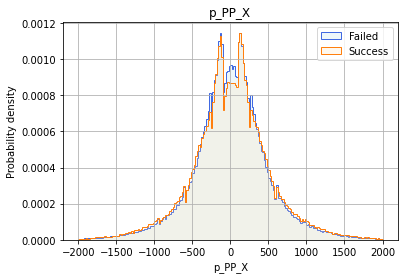

In [38]:
featureToPlot = 'p_PP_X'
featureLabel = 'p_PP_X'
featureTitle = 'p_PP_X'
binNumber = 200
boundaries = (-2000,2000)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

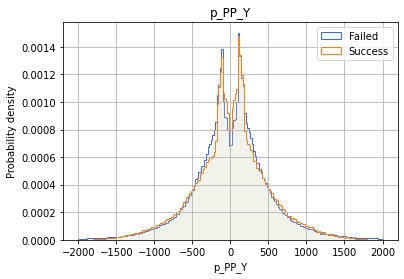

In [39]:
featureToPlot = 'p_PP_Y'
featureLabel = 'p_PP_Y'
featureTitle = 'p_PP_Y'
binNumber = 200
boundaries = (-2000,2000)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

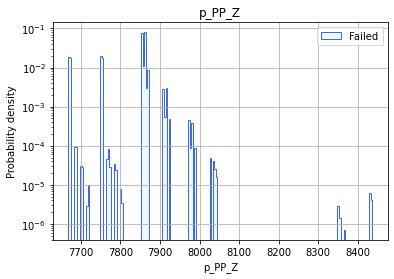

In [40]:
featureToPlot = 'p_PP_Z'
featureLabel = 'p_PP_Z'
featureTitle = 'p_PP_Z'
binNumber = 200
boundaries = (7668,8437)
yscale = 'log'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

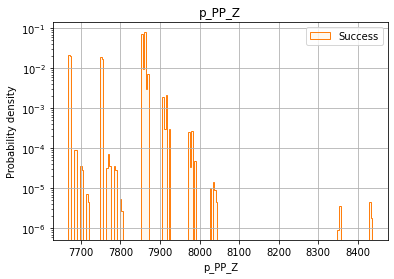

In [41]:
featureToPlot = 'p_PP_Z'
featureLabel = 'p_PP_Z'
featureTitle = 'p_PP_Z'
binNumber = 200
boundaries = (7668,8437)
yscale = 'log'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

## `p_PP_Weight`

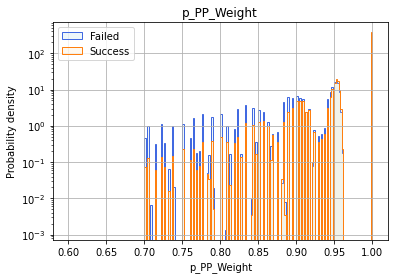

In [42]:
featureToPlot = 'p_PP_Weight'
featureLabel = 'p_PP_Weight'
featureTitle = 'p_PP_Weight'
binNumber = 200
boundaries = (0.6,1)
yscale = 'log'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend(loc=2)
plt.show()

## `p_PP_P`

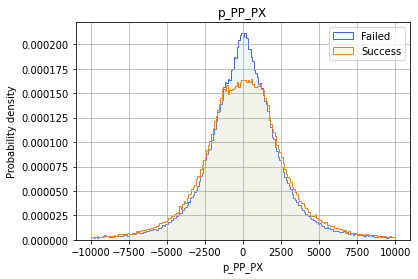

In [43]:
featureToPlot = 'p_PP_PX'
featureLabel = 'p_PP_PX'
featureTitle = 'p_PP_PX'
binNumber = 200
boundaries = (-1e4,1e4)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

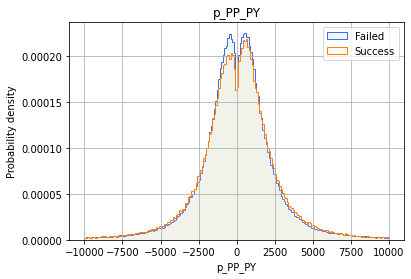

In [44]:
featureToPlot = 'p_PP_PY'
featureLabel = 'p_PP_PY'
featureTitle = 'p_PP_PY'
binNumber = 200
boundaries = (-1e4,1e4)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

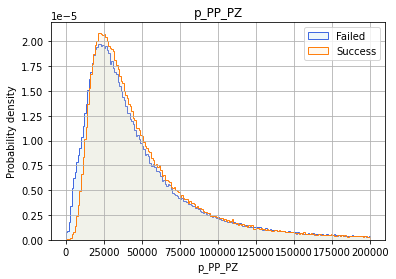

In [45]:
featureToPlot = 'p_PP_PZ'
featureLabel = 'p_PP_PZ'
featureTitle = 'p_PP_PZ'
binNumber = 200
boundaries = (0,2e5)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

## `pim_PP`

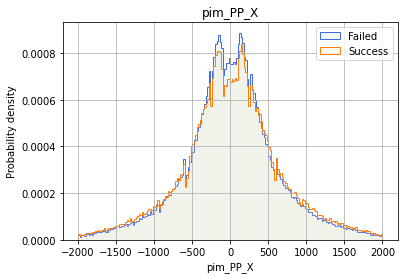

In [46]:
featureToPlot = 'pim_PP_X'
featureLabel = 'pim_PP_X'
featureTitle = 'pim_PP_X'
binNumber = 200
boundaries = (-2000,2000)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

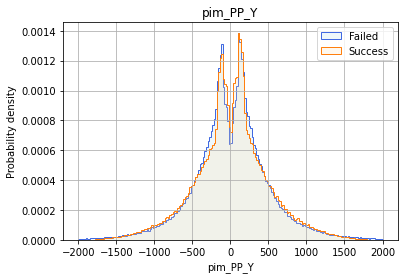

In [47]:
featureToPlot = 'pim_PP_Y'
featureLabel = 'pim_PP_Y'
featureTitle = 'pim_PP_Y'
binNumber = 200
boundaries = (-2000,2000)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

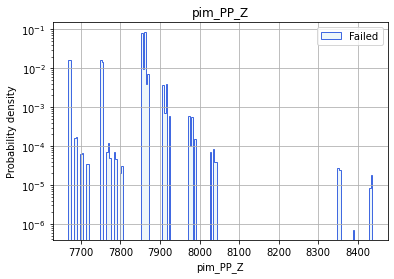

In [48]:
featureToPlot = 'pim_PP_Z'
featureLabel = 'pim_PP_Z'
featureTitle = 'pim_PP_Z'
binNumber = 200
boundaries = (7668,8437)
yscale = 'log'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

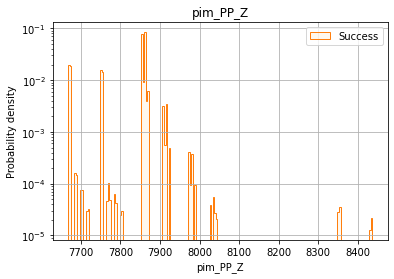

In [49]:
featureToPlot = 'pim_PP_Z'
featureLabel = 'pim_PP_Z'
featureTitle = 'pim_PP_Z'
binNumber = 200
boundaries = (7668,8437)
yscale = 'log'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

## `pim_PP_P`

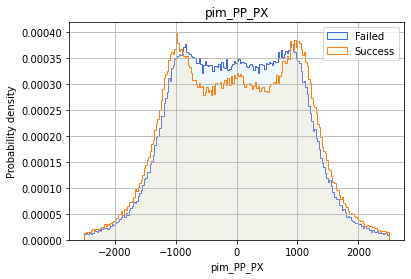

In [50]:
featureToPlot = 'pim_PP_PX'
featureLabel = 'pim_PP_PX'
featureTitle = 'pim_PP_PX'
binNumber = 200
boundaries = (-2500,2500)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

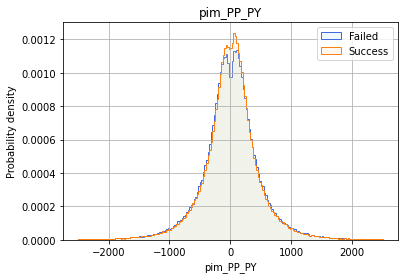

In [51]:
featureToPlot = 'pim_PP_PY'
featureLabel = 'pim_PP_PY'
featureTitle = 'pim_PP_PY'
binNumber = 200
boundaries = (-2500,2500)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

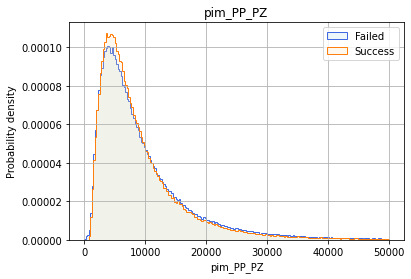

In [52]:
featureToPlot = 'pim_PP_PZ'
featureLabel = 'pim_PP_PZ'
featureTitle = 'pim_PP_PZ'
binNumber = 200
boundaries = (0,50000)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

## `pim_PP_Weight`

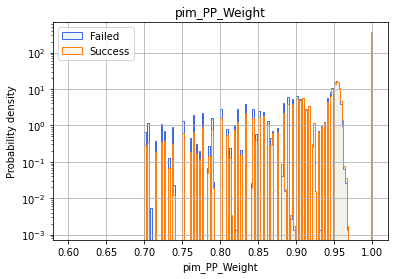

In [53]:
featureToPlot = 'pim_PP_Weight'
featureLabel = 'pim_PP_Weight'
featureTitle = 'pim_PP_Weight'
binNumber = 200
boundaries = (0.6,1)
yscale = 'log'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend(loc=2)
plt.show()

## `mum_PP`

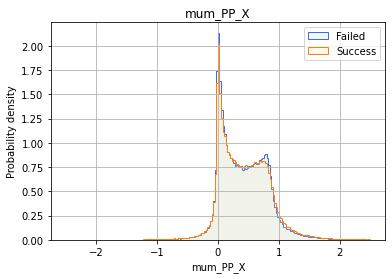

In [54]:
featureToPlot = 'mum_PP_X'
featureLabel = 'mum_PP_X'
featureTitle = 'mum_PP_X'
binNumber = 200
boundaries = (-2.5,2.5)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

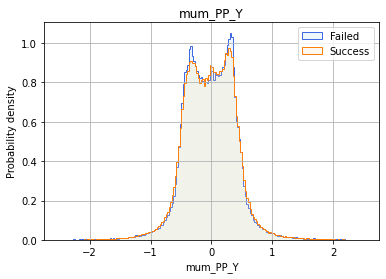

In [55]:
featureToPlot = 'mum_PP_Y'
featureLabel = 'mum_PP_Y'
featureTitle = 'mum_PP_Y'
binNumber = 200
boundaries = (-2.5,2.5)
yscale = 'linear'
normalized = True
if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

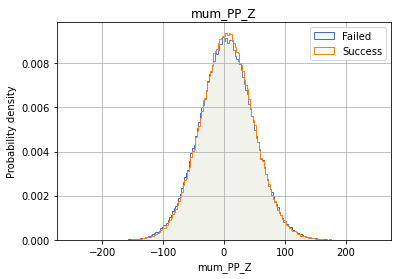

In [56]:
featureToPlot = 'mum_PP_Z'
featureLabel = 'mum_PP_Z'
featureTitle = 'mum_PP_Z'
binNumber = 200
boundaries = (-250,250)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

## `mum_PP_P`

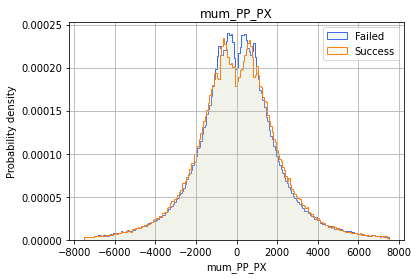

In [57]:
featureToPlot = 'mum_PP_PX'
featureLabel = 'mum_PP_PX'
featureTitle = 'mum_PP_PX'
binNumber = 200
boundaries = (-7500,7500)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

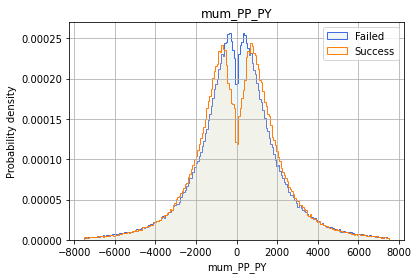

In [58]:
featureToPlot = 'mum_PP_PY'
featureLabel = 'mum_PP_PY'
featureTitle = 'mum_PP_PY'
binNumber = 200
boundaries = (-7500,7500)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

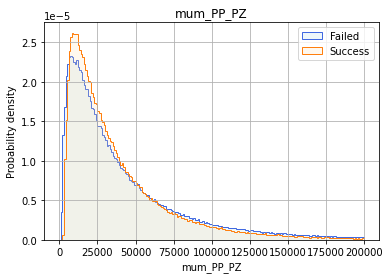

In [59]:
featureToPlot = 'mum_PP_PZ'
featureLabel = 'mum_PP_PZ'
featureTitle = 'mum_PP_PZ'
binNumber = 200
boundaries = (0,2e5)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

## `mum_PP_Weight`

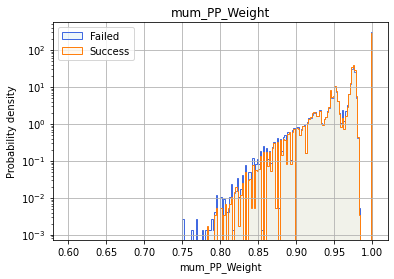

In [60]:
featureToPlot = 'mum_PP_Weight'
featureLabel = 'mum_PP_Weight'
featureTitle = 'mum_PP_Weight'
binNumber = 200
boundaries = (0.6,1)
yscale = 'log'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend(loc=2)
plt.show()

## `mup_PP`

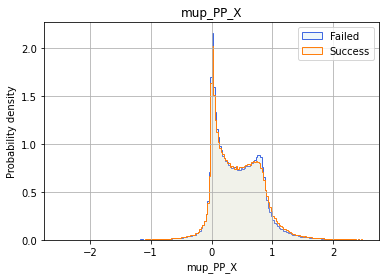

In [61]:
featureToPlot = 'mup_PP_X'
featureLabel = 'mup_PP_X'
featureTitle = 'mup_PP_X'
binNumber = 200
boundaries = (-2.5,2.5)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

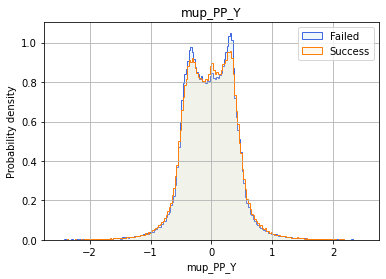

In [62]:
featureToPlot = 'mup_PP_Y'
featureLabel = 'mup_PP_Y'
featureTitle = 'mup_PP_Y'
binNumber = 200
boundaries = (-2.5,2.5)
yscale = 'linear'
normalized = True
if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

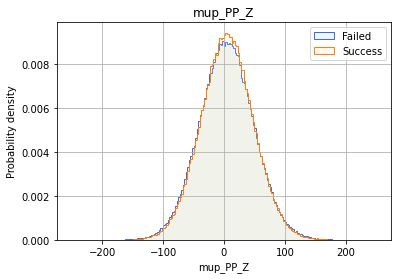

In [63]:
featureToPlot = 'mup_PP_Z'
featureLabel = 'mup_PP_Z'
featureTitle = 'mup_PP_Z'
binNumber = 200
boundaries = (-250,250)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

## `mup_PP_P`

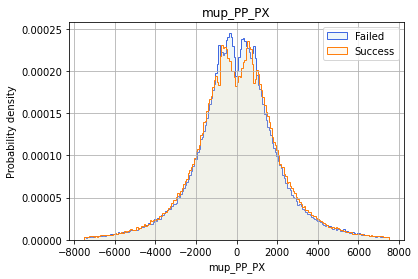

In [64]:
featureToPlot = 'mup_PP_PX'
featureLabel = 'mup_PP_PX'
featureTitle = 'mup_PP_PX'
binNumber = 200
boundaries = (-7500,7500)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

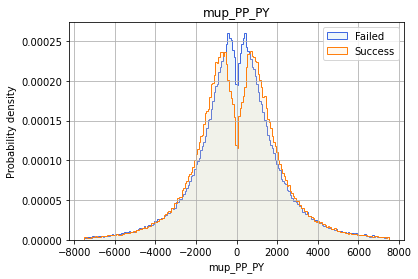

In [65]:
featureToPlot = 'mup_PP_PY'
featureLabel = 'mup_PP_PY'
featureTitle = 'mup_PP_PY'
binNumber = 200
boundaries = (-7500,7500)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

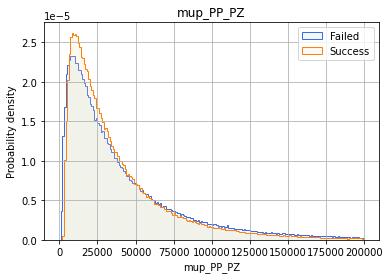

In [66]:
featureToPlot = 'mup_PP_PZ'
featureLabel = 'mup_PP_PZ'
featureTitle = 'mup_PP_PZ'
binNumber = 200
boundaries = (0,2e5)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

## `mup_PP_Weight`

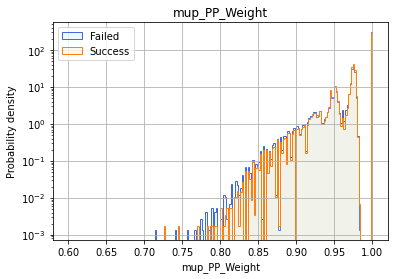

In [67]:
featureToPlot = 'mup_PP_Weight'
featureLabel = 'mup_PP_Weight'
featureTitle = 'mup_PP_Weight'
binNumber = 200
boundaries = (0.6,1)
yscale = 'log'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend(loc=2)
plt.show()

# Correlations

In [68]:
features = [
    'MCTRUTH_Lb_ENDVERTEX_X',
    'MCTRUTH_Lb_ENDVERTEX_Y',
    'MCTRUTH_Lb_ENDVERTEX_Z',
    'MCTRUTH_L_ENDVERTEX_X',
    'MCTRUTH_L_ENDVERTEX_Y',
    'MCTRUTH_L_ENDVERTEX_Z',
    'MCTRUTH_p_PX',
    'MCTRUTH_p_PY',
    'MCTRUTH_p_PZ',
    'MCTRUTH_pim_PX',
    'MCTRUTH_pim_PY',
    'MCTRUTH_pim_PZ',
    'MCTRUTH_mum_PX',
    'MCTRUTH_mum_PY',
    'MCTRUTH_mum_PZ',
    'MCTRUTH_mup_PX',
    'MCTRUTH_mup_PY',
    'MCTRUTH_mup_PZ',
    'MCTRUTH_Lb_ID',
    'MCTRUTH_L_ID',
    'Lb_Reconstructible',
    'Lb_Reconstructed',
    'L_Reconstructible',
    'L_Reconstructed',
    'Jpsi_Reconstructible',
    'Jpsi_Reconstructed',
    'p_Reconstructible',
    'p_Reconstructed',
    'pim_Reconstructible',
    'pim_Reconstructed',
    'mum_Reconstructible',
    'mum_Reconstructed',
    'mup_Reconstructible',
    'mup_Reconstructed',
    'p_PP_X',
    'p_PP_Y',
    'p_PP_Z',
    'p_PP_PX',
    'p_PP_PY',
    'p_PP_PZ',
    'p_PP_Weight',
    'pim_PP_X',
    'pim_PP_Y',
    'pim_PP_Z',
    'pim_PP_PX',
    'pim_PP_PY',
    'pim_PP_PZ',
    'pim_PP_Weight',
    'mum_PP_X',
    'mum_PP_Y',
    'mum_PP_Z',
    'mum_PP_PX',
    'mum_PP_PY',
    'mum_PP_PZ',
    'mum_PP_Weight',
    'mup_PP_X',
    'mup_PP_Y',
    'mup_PP_Z',
    'mup_PP_PX',
    'mup_PP_PY',
    'mup_PP_PZ',
    'mup_PP_Weight'
]

In [69]:
reco_covDF = df_MC_Reconstructed[features].corr()

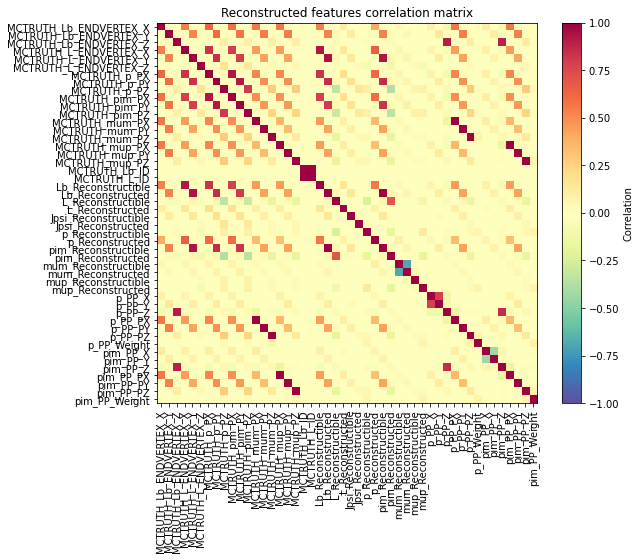

In [70]:
plt.figure(figsize=(9,7))
plt.matshow(reco_covDF, cmap='Spectral_r',fignum=0) ## Fignum=0 plots on current figure (matshow creates a new one by default)
plt.clim(-1,1)
plt.colorbar(label='Correlation')
plt.title("Reconstructed features correlation matrix")
ax = plt.gca() 
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_major_locator(ticker.FixedLocator(range(0,len(features))))
ax.xaxis.set_major_locator(ticker.FixedLocator(range(0,len(features))))
ax.set_xticklabels(features, rotation='vertical')
ax.set_yticklabels(features)
plt.show()

In [71]:
failed_covDF = df_MC_Failed[features].corr()

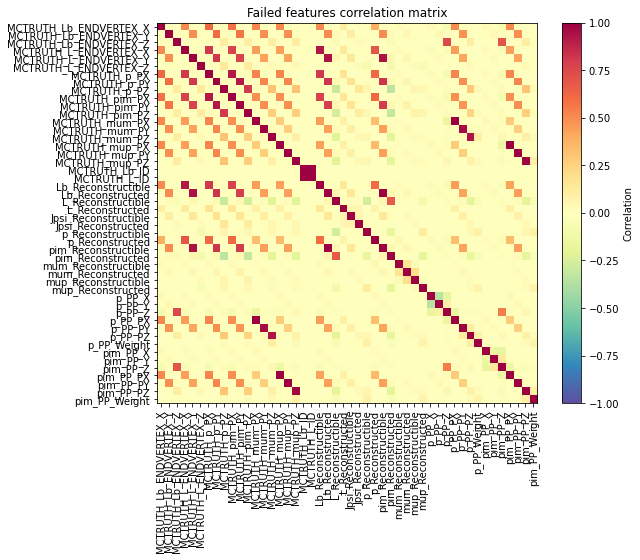

In [72]:
plt.figure(figsize=(9,7))
plt.matshow(failed_covDF, cmap='Spectral_r',fignum=0) ## Fignum=0 plots on current figure (matshow creates a new one by default)
plt.clim(-1,1)
plt.colorbar(label='Correlation')
plt.title("Failed features correlation matrix")
ax = plt.gca() 
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_major_locator(ticker.FixedLocator(range(0,len(features))))
ax.xaxis.set_major_locator(ticker.FixedLocator(range(0,len(features))))
ax.set_xticklabels(features, rotation='vertical')
ax.set_yticklabels(features)
plt.show()

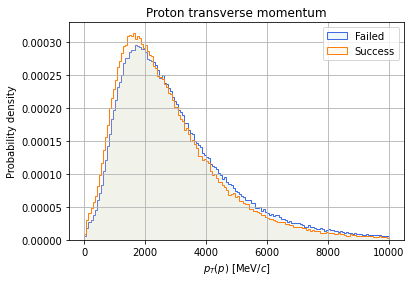

In [73]:
featureLabel = '$p_T (p)$ [MeV/$c$]'
featureTitle = 'Proton transverse momentum'
binNumber = 150
boundaries = (0,1e4)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    TransverseMomentumModulus(df_MC_Failed['MCTRUTH_p_PX'], df_MC_Failed['MCTRUTH_p_PY']),
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    TransverseMomentumModulus(df_MC_Reconstructed['MCTRUTH_p_PX'], df_MC_Reconstructed['MCTRUTH_p_PY']),
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

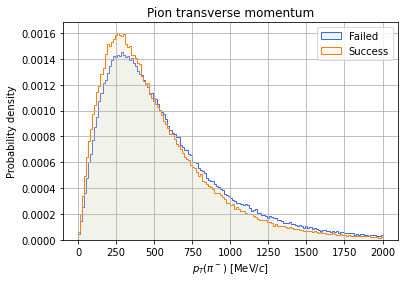

In [74]:
featureLabel = '$p_T (\pi^-)$ [MeV/$c$]'
featureTitle = 'Pion transverse momentum'
binNumber = 150
boundaries = (0,2000)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    TransverseMomentumModulus(df_MC_Failed['MCTRUTH_pim_PX'], df_MC_Failed['MCTRUTH_pim_PY']),
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    TransverseMomentumModulus(df_MC_Reconstructed['MCTRUTH_pim_PX'], df_MC_Reconstructed['MCTRUTH_pim_PY']),
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()